# Fleet features and Use Intensity
Developed by Alejandro Delgado

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm # not used for now
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geobr # information about municipalities shapefile
from shapely.geometry import box
import geopandas as gpd
from shapely.geometry import Polygon
%matplotlib inline

## Import Data
CETESB published a report called "Emissões Veiculares no Estado de São Paulo 2018" (CETESB 2019). This report contents information about `use intensity`, `emission factors by type of vehicle`, `number of vehicles`. Also, on the web page of [DENATRAN](https://infraestrutura.gov.br/component/content/article/115-portal-denatran/8558-frota-de-veiculos-2018.html) there is a specific information about the number of vehicles for each UF (states of Brazil) that it was downloaded for September 2018. So, based on the modeling domain, the number of vehicles is summed to used after in the `wrfchemi_cbmz_fc.ncl` through the `namelist_fc.emi`:

```
&caracteristicas_frota            ! SETEMBRO 2018
 n_veic           = 9,            ! NUMERO DE TIPOS DE VEICULO
 frota_veicular   = xxxxxxxxx,    ! FROTA TOTAL EXISTENTE PARA O PERIODO ANALISADO
 veic_gasolina    = x.xxxxxxx,    ! FRACAO VEICULOS MOVIDOS A GASOLINA (VEIC 1)
 veic_etanol      = x.xxxxxxx,    ! FRACAO VEICULOS MOVIDOS A ETANOL (VEIC 2)
 veic_flex        = x.xxxxxxx,    ! FRACAO VEICULOS MOVIDOS A FLEX (VEIC 3)
 veic_caminhoes   = x.xxxxxxx,    ! FRACAO CAMINHOES (DIESEL - VEIC 4A)
 veic_urbanos     = x.xxxxxxx,    ! FRACAO ONIBUS URBANO (DIESEL - VEIC 4B)
 veic_rodoviarios = x.xxxxxxx,    ! FRACAO ONIBUS RODOVIARIO (DIESEL - VEIC 4C)
 veic_taxis       = x.xxxxxxx,    ! FRACAO TAXIS (GAS - VEIC 5)
 veic_moto_gaso   = x.xxxxxxx,    ! FRACAO MOTOS MOVIDOS A GASOLINA (VEIC 6A)
 veic_moto_flex   = x.xxxxxxx,    ! FRACAO MOTOS FLEX (VEIC 6B)
 frota_ativa      = 1,            ! FRACAO FROTA ATIVA (1=100%)
/

! Fatores de emissao baseados em Perez-Martinez et al. (2014) e Andrade et al. (2015)
&fator_emissao    ! VEIC 1,  VEIC 2,  VEIC 3,  VEIC4A,  VEIC4B,  VEIC4C,  VEIC 5,  VEIC6A,  VEIC6B
 exa_co           = 5.8000,  12.000,  5.8000,  3.6000,  3.6000,  3.6000,  0.0000,  9.1500,  9.0200,
 exa_co2          = 219.00,  219.00,  219.00,  1422.0,  1422.0,  1422.0,  0.0000,  0.0000,  0.0000,
 exa_nox          = 0.3000,  1.1200,  0.3000,  9.2000,  9.2000,  9.2000,  0.0000,  0.1320,  0.1290,
 exa_so2          = 0.0290,  0.0140,  0.0210,  0.6100,  0.6100,  0.6100,  0.0000,  0.0097,  0.0093,
 exa_c2h5oh       = 0.5080,  0.2500,  0.5080,  0.6100,  0.6100,  0.6100,  0.0000,  0.0790,  0.3050,
 exa_hcho         = 0.0089,  0.0110,  0.0098,  0.6100,  0.6100,  0.6100,  0.0000,  0.0152,  0.0155,
 exa_ald          = 0.0140,  0.0300,  0.0220,  0.6100,  0.6100,  0.6100,  0.0000,  0.0164,  0.0188,
 exa_pm           = 0.0200,  0.0200,  0.0200,  0.2770,  0.2770,  0.2770,  0.0000,  0.0500,  0.0500,
 exa_voc          = 0.4250,  1.3000,  0.4340,  2.0500,  2.0500,  2.0500,  0.0000,  1.0800,  1.0800,
 vap_voc          = 0.2300,  0.2500,  0.2400,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
 liq_voc          = 2.0000,  1.5000,  1.7500,  0.0000,  0.0000,  0.0000,  0.0000,  1.2000,  1.2000,
/
 
&intensidade_uso                  ! ano 2018
 kmd_veic123      = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 1, 2 E 3
 kmd_veic4a       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 4A
 kmd_veic4b       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 4B
 kmd_veic4c       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 4C
 kmd_veic5        = 0.,           ! QUILOMETRAGEM DIARIA - VEICULOS 5
 kmd_veic6a       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 6A
 kmd_veic6b       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 6B
/
```

The model domain area covers different "UF" or states:

|UF code |	Federation Unit | UF|
|----------|------------------------ |---|
31	|Minas Gerais |	MG
32	|Espírito Santo |	ES
33	|Rio de Janeiro |	RJ
35	|São Paulo	|SP
41 | Paraná	|PR
42 | Santa Catarina|	SC
43 | Rio Grande do Su| RS
50|Mato Grosso do Sul|MS
52 | Goiás| GO

So, our objetive is to obtain results about `caracteristicas_frota`, and `intensidade_uso`. The information collected is in the Excel File `DATA_EF.xlsx`:

In [2]:
df = pd.ExcelFile(r'../2_Emissions_inventory/LAPAt_mod/DATA_EF.xlsx')
df.sheet_names

['VehCETESB2018',
 'EmCETESB2018',
 'fleet_age',
 'Use intensity',
 'EF_CETESB',
 'DenatranSet2018']

The type of vehicles is defined in the follow table and corresponds to the CETESB (2019) Emissions Report, referenced previously:

In [3]:
vehCET = df.parse('VehCETESB2018')
Cat = pd.DataFrame([['PC_G','PC_E', 'PC_F','LCV_G','LCV_E','LCV_F','LCV_D',
                    'LT','SLT','MT','SHT','HT','SUB','UB','UBA','MC_G','MC_F']]).T

vehCET['Cat'] = Cat
print(vehCET.iloc[:,:-1].to_latex(caption='Vehicular fleet by type and fuel',label = 'tab:fleet', longtable = True,index=False))


\begin{longtable}{lllr}
\caption{Vehicular fleet by type and fuel}\label{tab:fleet}\\
\toprule
      ID &                         Category &          Fuel &  Veh/year \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
  VEIC 1 &               Passenger Car (PC) &    Gasoline C &   2686720 \\
  VEIC 2 &               Passenger Car (PC) &       Ethanol &    203893 \\
  VEIC 3 &               Passenger Car (PC) &     Flex-fuel &   7402653 \\
  VEIC 1 &  Light Commercial Vehicles (LCV) &    Gasoline C &    503522 \\
  VEIC 2 &  Light Commercial Vehicles (LCV) &  Ethanol Hid. &     19460 \\
  VEIC 3 &  Light Commercial Vehicles (LCV) &     Flex-fuel &    959325 \\
 VEIC 4A &  Light Commercial Vehicles (LCV) &        Diesel &    427788 \\
 VEIC 4A &                 Light Truck (LT) &        Diesel &     32662 \\
 VEIC 4A &           Semi Light Truck (SLT) &        Diesel &    107579 \\
 VEIC 4A &                Medium Tru

In [4]:
print(f"Veh/year for São Paulo state (CETESB): {vehCET['Veh/year'].sum()}")

Veh/year for São Paulo state (CETESB): 15266361


Emissions ratio (year 2018) for São Paulo in (t), according to CETESB (2019).

In [5]:
emCET = df.parse('EmCETESB2018',skiprows=1, index_col=None, na_values=['nd'])
emCET

,ID,Category,Fuel,CO,NOx,MP,SO2,COV
0,VEIC 1,Passenger Car (PC),Gasoline C,88064,11558,49.0,125.0,17901
1,VEIC 2,Passenger Car (PC),Ethanol,18093,1443,NaN,NaN,3528
2,VEIC 3,Passenger Car (PC),Flex-fuel,72144,6157,38.0,104.0,21737
3,VEIC 1,Light Commercial Vehicles (LCV),Gasoline C,15458,1611,9.0,34.0,4167
4,VEIC 2,Light Commercial Vehicles (LCV),Ethanol Hid.,1522,135,NaN,NaN,377
5,VEIC 3,Light Commercial Vehicles (LCV),Flex-fuel,12836,1175,6.0,22.0,3695
6,VEIC 4A,Light Commercial Vehicles (LCV),Diesel,1595,7117,300.0,352.0,417
7,VEIC 4A,Light Truck (LT),Diesel,401,2138,97.0,57.0,125
8,VEIC 4A,Semi Light Truck (SLT),Diesel,1830,10264,409.0,278.0,527
9,VEIC 4A,Medium Truck (MT),Diesel,1200,6767,320.0,165.0,373


In [6]:
fleet_age = df.parse('fleet_age',skiprows=0, index_col=None, na_values=['nd'])
fleet_age.head()

,Year,PC_G,PC_E,PC_FG,PC_FE,LCV_G,LCV_E,LCV_FG,LCV_FE,LCV_D,...,UBA,MC_150_G,MC_150_500_G,MC_500_G,MC_150_FG,MC_150_500_FG,MC_500_FG,MC_150_FE,MC_150_500_FE,MC_500_FE
0,2018,31183.375389,0.0,248133.886716,293212.622585,192.747848,0.0,18244.922037,21559.495601,32764.000000,...,1343.053500,76818.000000,10974.000000,3658.000000,37204.596532,5827.225963,1792.992604,43963.593468,6885.864037,2118.727396
1,2017,26616.633790,0.0,215417.386066,254552.481947,285.379399,0.0,18648.925383,22036.894647,22703.994996,...,1062.352780,62027.817600,8861.116800,2953.705600,28120.759861,4404.456364,1355.217343,33229.486939,5204.618436,1601.421057
2,2016,31046.730923,0.0,194995.003356,230419.944175,311.890775,0.0,18207.852100,21515.691131,23073.928052,...,742.848914,41161.516368,5880.216624,1960.072208,26570.667076,4161.670747,1280.514076,31397.787220,4917.725709,1513.146372
3,2015,48907.142477,0.0,241824.269939,285756.731302,769.635009,0.0,22302.417179,26354.120018,39474.796286,...,1222.995220,52670.055756,7524.293679,2508.097893,35873.634401,5618.762015,1728.849851,42390.834092,6639.528231,2042.931763
4,2014,34511.632752,0.0,286359.083347,338382.229612,28793.658147,0.0,58217.089598,68793.447546,43044.628768,...,1920.905010,70325.213053,10046.459008,3348.819669,30601.510756,4793.007709,1474.771603,36160.918376,5663.758300,1742.694861


The Excel Sheet `Use Intensity` has information about km/year for type of vehicle:

In [7]:
useCol = df.parse('Use intensity',skiprows=0, index_col=None, na_values=['nd'])[0:2]
useCol

,Unnamed: 0,Unnamed: 1,km/year,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,NaN,Use per year,VEIC 1,VEIC 2,VEIC 3,VEIC 1,VEIC 2,VEIC 3,VEIC 4A,VEIC 6,VEIC 4B,VEIC 4B,VEIC 4C,VEIC 4A,VEIC 4A,VEIC 4A,VEIC 4A,VEIC 4A
1,Year,Year_ID,PC gasoline,PC ethanol,PC flex-fuel,LCV gasoline,LCV ethanol,LCV flex-fuel,LCV Diesel,MC,UB - Diesel,SUB - Diesel,UBA - Diesel,SLT - Diesel,LT - Diesel,MT - Diesel,SHT - Diesel,HT - Diesel


In [8]:
use = df.parse('Use intensity',skiprows=2, index_col=None, na_values=['nd'])
use.head()

,Year,Year_ID,PC gasoline,PC ethanol,PC flex-fuel,LCV gasoline,LCV ethanol,LCV flex-fuel,LCV Diesel,MC,UB - Diesel,SUB - Diesel,UBA - Diesel,SLT - Diesel,LT - Diesel,MT - Diesel,SHT - Diesel,HT - Diesel
0,2018,1,11997,NaN,17220.0,17933,NaN,18220.0,28443,12807.0,62470,35578,62470,41083,41083,41083,56223,56223
1,2017,2,12632,NaN,15968.0,17638,NaN,21110.0,27358,13078.0,58979,31654,58979,38117,38117,38117,55200,55200
2,2016,3,13177,NaN,15277.0,17320,NaN,21914.0,26321,13243.0,55908,29359,55908,35564,35564,35564,54176,54176
3,2015,4,13635,NaN,15001.0,16981,NaN,21277.0,25270,13313.0,53205,27730,53205,33386,33386,33386,53152,53152
4,2014,5,14009,NaN,14995.0,16623,NaN,19843.0,24142,13293.0,50816,26467,50816,31543,31543,31543,52129,52129


About DENATRAN information, this data contents many details about number of vehicles for September, 2018.

In [9]:
vehSep18 = df.parse('DenatranSet2018', skiprows=0, index_col=None, na_values=['nd'])
vehSep18

,UF,MUNICIPIO,TOTAL,AUTOMOVEL,BONDE,CAMINHAO,CAMINHAO TRATOR,CAMINHONETE,CAMIONETA,CHASSI PLATAF,...,ONIBUS,QUADRICICLO,REBOQUE,SEMI-REBOQUE,SIDE-CAR,OUTROS,TRATOR ESTEI,TRATOR RODAS,TRICICLO,UTILITARIO
0,AC,ACRELANDIA,5481,1197,0,247,22,569,44,0,...,43,0,45,29,0,0,0,0,0,7
1,AC,ASSIS BRASIL,1639,288,0,22,0,133,18,0,...,2,0,9,0,0,0,0,0,0,1
2,AC,BRASILEIA,8657,2056,0,263,109,989,68,0,...,18,0,89,158,0,0,0,0,3,24
3,AC,BUJARI,1951,564,0,110,23,243,17,0,...,12,0,20,24,0,0,0,0,1,3
4,AC,CAPIXABA,1964,547,0,80,2,211,23,0,...,13,0,21,3,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5566,TO,TOCANTINOPOLIS,20323,3462,0,1167,204,1350,213,0,...,387,0,564,362,0,0,0,3,11,25
5567,TO,TUPIRAMA,484,137,0,24,8,49,4,0,...,5,0,12,19,0,0,0,0,0,1
5568,TO,TUPIRATINS,372,94,0,11,1,36,5,0,...,9,0,10,3,0,0,0,0,0,0
5569,TO,WANDERLANDIA,1957,574,0,66,21,179,38,0,...,12,0,53,25,0,0,0,0,0,3


## Fleet Characteristics
Based on `vehCET`, fleet fractions by type could be calculate:

In [10]:
fraction = vehCET.groupby('ID').sum()/vehCET['Veh/year'].sum()
fraction

,Veh/year
ID,
VEIC 1,0.208972
VEIC 2,0.014630
VEIC 3,0.547739
VEIC 4A,0.056697
VEIC 4B,0.005071
VEIC 4C,0.001850
VEIC 6A,0.119445
VEIC 6B,0.045596


So, for now we have information about the fraction by vehicle type:

```
&caracteristicas_frota           ! SETEMBRO 2018
 n_veic           = 9,           ! NUMERO DE TIPOS DE VEICULO
 frota_veicular   = xxxxxxxx,    ! FROTA TOTAL EXISTENTE PARA O PERIODO ANALISADO
 veic_gasolina    = 0.208972,    ! FRACAO VEICULOS MOVIDOS A GASOLINA (VEIC 1)
 veic_etanol      = 0.014630,    ! FRACAO VEICULOS MOVIDOS A ETANOL (VEIC 2)
 veic_flex        = 0.547739,    ! FRACAO VEICULOS MOVIDOS A FLEX (VEIC 3)
 veic_caminhoes   = 0.056697,    ! FRACAO CAMINHOES (DIESEL - VEIC 4A)
 veic_urbanos     = 0.005071,    ! FRACAO ONIBUS URBANO (DIESEL - VEIC 4B)
 veic_rodoviarios = 0.001850,    ! FRACAO ONIBUS RODOVIARIO (DIESEL - VEIC 4C)
 veic_taxis       = 0.000000,    ! FRACAO TAXIS (GAS - VEIC 5)
 veic_moto_gaso   = 0.119445,    ! FRACAO MOTOS MOVIDOS A GASOLINA (VEIC 6A)
 veic_moto_flex   = 0.045596,    ! FRACAO MOTOS FLEX (VEIC 6B)
 frota_ativa      = 1,           ! FRACAO FROTA ATIVA (1=100%)
/
```

For this first task, we need to finalize with the calculation of `frota_veicular` (total fleet). To do this, we need to calculate the number of vehicles inside our domain area, approximately:

Domain | Point        | Longitude (º) | Latitude (º)
-------| ------------ |-------------- | ------------
D01    | South-west   | -53.53        |  -27.70
       | North-east   | -39.69        |  -19.30
D02    | South-west   | -49.01        |  -25.05
       | North-east   | -44.36        |  -21.64


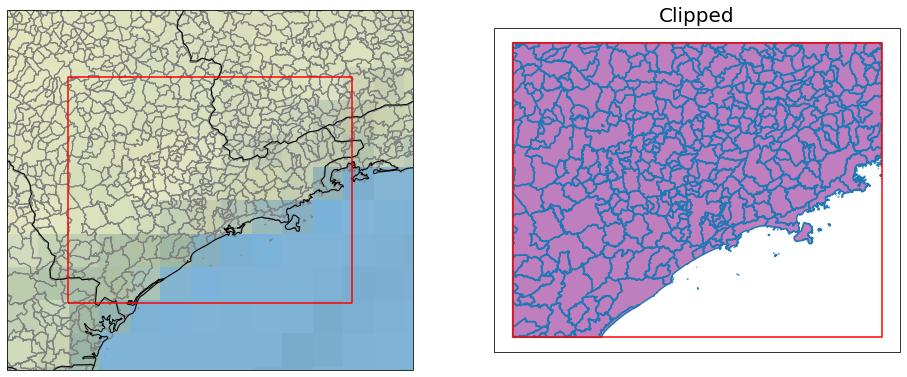

In [13]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
plt.figure(figsize=(16, 12))
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())

# Domain 01
# lon1 = -53.53; lat1 = -27.70; lon2 = -39.69; lat2 = -19.30

# Domain 02
lon1 = -49.01; lat1 = -25.05; lon2 = -44.36; lat2 = -21.64

# Create a figure #
# --------------- #
ax1.set_extent([lon1-1, lon2+1, lat1-1, lat2+1], crs=ccrs.PlateCarree())

# Put a background image on for nice sea rendering.
ax1.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(states_provinces, edgecolor='black')
mun = geobr.read_municipality(code_muni='all', year=2018)
mun.plot(facecolor="none",alpha=1, edgecolor='gray', ax=ax1)
polygon = Polygon([(lon1, lat1), (lon1, lat2), (lon2, lat2), (lon2, lat1), (lon1, lat1)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=mun.crs)
poly_gdf.boundary.plot(ax=ax1, color="red")

munDomain = gpd.clip(mun, polygon) ## This is very important
munDomain = munDomain.sort_values(by='abbrev_state')

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
munDomain.plot(ax=ax2, color="purple", alpha = 0.5)
munDomain.boundary.plot(ax=ax2)
poly_gdf.boundary.plot(ax=ax2, color="red")
ax2.set_title("Clipped", fontsize=20);

For now, we have names of Municipalities inside our model domain area in `munDomain`. We are going to call as `munNAMES`:

In [14]:
munnames = list(munDomain.name_muni.values)
munNAMES = [x.upper() for x in munnames]
import unicodedata
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

munNAMES = [strip_accents(x) for x in munNAMES]
munDomain['MUNICIPIO'] = munNAMES
print("munNAMES: ",munNAMES[0:10], "...","\n \n", "Number of Municipalities: ",munDomain.name_muni.count())

munNAMES:  ['AIURUOCA', 'POUSO ALEGRE', 'POCOS DE CALDAS', 'POCO FUNDO', 'PIRANGUINHO', 'PIRANGUCU', 'PEDRALVA', 'PASSA QUATRO', 'PARAISOPOLIS', 'PARAGUACU'] ... 
 
 Number of Municipalities:  402


Now, columns names of `vehSep18` have the type of vehicles that doesn't correspond to the vehicle category that we need. So we are going to filter this information:

```python
In [1]: vehSep18.columns
Out[2]: Index(['UF', 'MUNICIPIO', 'TOTAL', 'AUTOMOVEL', 'BONDE', 'CAMINHAO',
       'CAMINHAO TRATOR', 'CAMINHONETE', 'CAMIONETA', 'CHASSI PLATAF',
       'CICLOMOTOR', 'MICRO-ONIBUS', 'MOTOCICLETA', 'MOTONETA', 'ONIBUS',
       'QUADRICICLO', 'REBOQUE', 'SEMI-REBOQUE', 'SIDE-CAR', 'OUTROS',
       'TRATOR ESTEI', 'TRATOR RODAS', 'TRICICLO', 'UTILITARIO'],
      dtype='object')
```
The equivalent category is understandable as following:

DENATRAN category | Category for Emissions Analysis
------------------| -----------------| 
AUTOMOVEL | Passenger Car (PC)
BONDE | -
CAMINHAO | Heavy Truck (HT)
CAMINHAO TRATOR | Light Truck (LT)
| Semi Light Truck (SLT)
|Medium Truck (MT)
| Semi Heavy Truck (SHT)
CAMINHONETE | Passenger Car (PC)
CAMIONETA | Passenger Car (PC)
CHASSI PLATAF | -
CICLOMOTOR | Motorcycle (MC)
MICRO-ONIBUS | Small Urban Bus (SUB)
MOTOCICLETA | Motorcycle (MC)
MOTONETA | Motorcycle (MC)
ONIBUS | Urban Bus (UB)
| Urban Bus Articulated (UBA)
QUADRICICLO | -
REBOQUE | -
SEMI-REBOQUE | -
SIDE-CAR | -
OUTROS | -
TRATOR ESTEI | Considered as Truck
TRATOR RODAS | Considered as Truck
TRICICLO | -
UTILITARIO | Light Commercial Vehicles (LCV)


In [15]:
UF = ['MG', 'ES', 'RJ', 'SP', 'PR', 'SC', 'RS', 'MS', 'GO']
vehUF = vehSep18[vehSep18.UF.isin(UF)]
vehs = ['AUTOMOVEL', 'CAMINHAO'    , 'CAMINHAO TRATOR', 'CAMINHONETE', 'CAMIONETA', 
       'CICLOMOTOR', 'MICRO-ONIBUS', 'MOTOCICLETA'    , 'MOTONETA'   , 'ONIBUS'   ,
       'TRATOR ESTEI', 'TRATOR RODAS', 'UTILITARIO']

vehUF = vehUF.filter(['UF','MUNICIPIO']+vehs)
vehUF['TOTAL'] = vehUF.sum(axis = 1)
print(vehUF[['UF','MUNICIPIO','TOTAL']], "\n") # vehUF[['UF','MUNICIPIO','Total']]

print(munDomain.sort_values(by='abbrev_state')[['abbrev_state','MUNICIPIO']], "\n")

vehMunDom = vehUF[vehUF.MUNICIPIO.isin(munNAMES)]
print(vehMunDom[['UF','MUNICIPIO','TOTAL']], "\n")

print(vehMunDom.groupby('UF').sum(),"\n \n TOTAL Fleet: ",(vehMunDom['TOTAL'].sum()).round(0))

      UF             MUNICIPIO  TOTAL
804   ES        AFONSO CLAUDIO  19001
805   ES    AGUA DOCE DO NORTE   5115
806   ES          AGUIA BRANCA   5280
807   ES                ALEGRE  13238
808   ES        ALFREDO CHAVES   9308
...   ..                   ...    ...
5427  SP  VISTA ALEGRE DO ALTO   4522
5428  SP        VITORIA BRASIL    950
5429  SP            VOTORANTIM  67541
5430  SP           VOTUPORANGA  80148
5431  SP              ZACARIAS   1521

[3185 rows x 3 columns] 

     abbrev_state        MUNICIPIO
2255           MG         AIURUOCA
2257           MG        ALBERTINA
2271           MG         ANDRADAS
2273           MG      ANDRELANDIA
2297           MG         BAEPENDI
...           ...              ...
3901           SP  VARZEA PAULISTA
3903           SP          VINHEDO
3907           SP       VOTORANTIM
3830           SP        SAO PEDRO
3459           SP   GAVIAO PEIXOTO

[402 rows x 2 columns] 

      UF               MUNICIPIO  TOTAL
1086  GO            SANTA ISABE

So, with this result we can complete the first task that is to obtain fleet characteristics for each domain (D01 and D02):

For domain D01 (15 km of spatial resolution):
```
&caracteristicas_frota           ! SETEMBRO 2018
 n_veic           = 9,           ! NUMERO DE TIPOS DE VEICULO
 frota_veicular   = 56410975,    ! FROTA TOTAL EXISTENTE PARA O PERIODO ANALISADO
 veic_gasolina    = 0.208972,    ! FRACAO VEICULOS MOVIDOS A GASOLINA (VEIC 1)
 veic_etanol      = 0.014630,    ! FRACAO VEICULOS MOVIDOS A ETANOL (VEIC 2)
 veic_flex        = 0.547739,    ! FRACAO VEICULOS MOVIDOS A FLEX (VEIC 3)
 veic_caminhoes   = 0.056697,    ! FRACAO CAMINHOES (DIESEL - VEIC 4A), PESADO
 veic_urbanos     = 0.005071,    ! FRACAO ONIBUS URBANO (DIESEL - VEIC 4B), PESADO
 veic_rodoviarios = 0.001850,    ! FRACAO ONIBUS RODOVIARIO (DIESEL - VEIC 4C), PESADO
 veic_taxis       = 0.000000,    ! FRACAO TAXIS (GAS - VEIC 5)
 veic_moto_gaso   = 0.119445,    ! FRACAO MOTOS MOVIDOS A GASOLINA (VEIC 6A)
 veic_moto_flex   = 0.045596,    ! FRACAO MOTOS FLEX (VEIC 6B)
 frota_ativa      = 1,           ! FRACAO FROTA ATIVA DE VEICULOS LEVES, NAO PESADOS (1=100%)
/
```
For domain D02 (3 km of spatial resolution), we can change `frota_veicular` value equals to 24 259 504.

## Use Intensity (kmd) by type of vehicle
We need to calculate this information:
```
&intensidade_uso                  ! ano 2018
 kmd_veic123      = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 1, 2 E 3
 kmd_veic4a       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 4A
 kmd_veic4b       = xxx.xx,       ! QUILOMETRAGEM DIARIA - VEICULOS 4B
 kmd_veic4c       = xxx.x,       ! QUILOMETRAGEM DIARIA - VEICULOS 4C
 kmd_veic5        = 0.,           ! QUILOMETRAGEM DIARIA - VEICULOS 5
 kmd_veic6a       = xx.xx,        ! QUILOMETRAGEM DIARIA - VEICULOS 6A
 kmd_veic6b       = xx.xx,         ! QUILOMETRAGEM DIARIA - VEICULOS 6B
/
```

In [16]:
# Veic123
use_veic123 = ['PC gasoline','PC ethanol','PC flex-fuel','LCV gasoline','LCV ethanol','LCV flex-fuel']
n_fleet123  = ['PC_G', 'PC_E', 'PC_FG', 'PC_FE', 'LCV_G', 'LCV_E', 'LCV_FG','LCV_FE']

def use_int(use_list= use_veic123,fleet_list= n_fleet123):
    use_veic = use[['Year']]
    use_veic['kmd'] = use[use_list].mean(axis=1)/365
    use_veic['n_veic'] = fleet_age[fleet_list].sum(axis=1)
    kmd_veic = (use_veic['kmd']*use_veic['n_veic']).sum()/use_veic['n_veic'].sum()
    return kmd_veic

# Veic 4a
use_veic4a = ['LCV Diesel','SLT - Diesel','LT - Diesel', 'MT - Diesel','SHT - Diesel', 'HT - Diesel']
n_fleet4a  = ['LCV_D', 'SLT', 'LT', 'MT', 'SHT', 'HT']

# Veic 4b
use_veic4b = ['UB - Diesel', 'SUB - Diesel']
n_fleet4b  = ['UB', 'SUB']

# Veic 4c
use_veic4c = ['UBA - Diesel']
n_fleet4c  = ['UBA']

# Veic 6a
use_veic6a = ['MC']
n_fleet6a  = ['MC_150_G', 'MC_150_500_G', 'MC_500_G']

# Veic 6b
use_veic6b = ['MC']
n_fleet6b  = ['MC_150_FG', 'MC_150_500_FG','MC_500_FG', 'MC_150_FE', 'MC_150_500_FE', 'MC_500_FE']

print("kmd_veic123 = ",use_int(use_list= use_veic123,fleet_list= n_fleet123).round(2))
print("kmd_veic4a = ",use_int(use_list= use_veic4a,fleet_list= n_fleet4a).round(2))
print("kmd_veic4b = ",use_int(use_list= use_veic4b,fleet_list= n_fleet4b).round(2))
print("kmd_veic4c = ",use_int(use_list= use_veic4c,fleet_list= n_fleet4c).round(2))
print("kmd_veic6a = ",use_int(use_list= use_veic6a,fleet_list= n_fleet6a).round(2))
print("kmd_veic6b = ",use_int(use_list= use_veic6b,fleet_list= n_fleet6b).round(2))

kmd_veic123 =  39.39
kmd_veic4a =  91.02
kmd_veic4b =  86.7
kmd_veic4c =  106.18
kmd_veic6a =  32.16
kmd_veic6b =  35.78


<ipython-input-16-991db5f03396>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_veic['kmd'] = use[use_list].mean(axis=1)/365
<ipython-input-16-991db5f03396>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_veic['n_veic'] = fleet_age[fleet_list].sum(axis=1)


With these results we have use intensities in km/day, considering different vehicles until 40 years old:
```
&intensidade_uso                  ! ano 2018
 kmd_veic123      = 39.39,        ! QUILOMETRAGEM DIARIA - VEICULOS 1, 2 E 3
 kmd_veic4a       = 91.02,        ! QUILOMETRAGEM DIARIA - VEICULOS 4A
 kmd_veic4b       = 86.70,        ! QUILOMETRAGEM DIARIA - VEICULOS 4B
 kmd_veic4c       = 106.18,       ! QUILOMETRAGEM DIARIA - VEICULOS 4C
 kmd_veic5        = 0.,           ! QUILOMETRAGEM DIARIA - VEICULOS 5
 kmd_veic6a       = 32.16,        ! QUILOMETRAGEM DIARIA - VEICULOS 6A
 kmd_veic6b       = 35.78,        ! QUILOMETRAGEM DIARIA - VEICULOS 6B
/
```

## Emissions Calculation for the Modeling Domain
Emissions showed in `emCET` represents only for São Paulo state. We are going to calculate equivalent emissions for our modeling domain, based on number of vehicles:

In [17]:
V_SP = vehUF[vehUF.UF == 'SP']['TOTAL'].sum()
V_MD = (vehMunDom['TOTAL'].sum()).round(0)
print("Vehicles for São Paulo state (DENATRAN): \t",V_SP)
print("Vehicles for modeling domain (DENATRAN): \t",V_MD)

Vehicles for São Paulo state (DENATRAN): 	 28223364
Vehicles for modeling domain (DENATRAN): 	 24259504


Total pollutant emissions (units in kt/year) from vehicles of São Paulo state (E$_{SP}$) are:

In [18]:
print(emCET[['CO','NOx','MP','SO2','COV']].sum()/1000)

CO     314.847
NOx    147.680
MP       3.890
SO2      4.353
COV     66.828
dtype: float64


Based on these results, we can calculate representative total emissions (E$_{MD}$) of the modeling domain. To do this, we use a Top-Down approximation:

\begin{align}
E_{SP} (t)  & \rightarrow 28~223~364 \ veh. \\
E_{MD\_d01} (t)  & \rightarrow 56~410~975 \ veh. \\
E_{MD\_d02} (t)  & \rightarrow 24~259~504 \ veh.
\end{align}


In [19]:
pol = ['CO','NOx','SO2','MP','COV']
E_MD=emCET[pol].sum()*V_MD/V_SP
print("Emissions in kt/year for modeling domain:")
for i in range(len(pol)):
    print(pol[i],"\t",(E_MD.round(0)/1000).values[i])
print("CO2-eq\t",((37825*V_MD)/V_SP).round(3))

Emissions in kt/year for modeling domain:
CO 	 270.628
NOx 	 126.939
SO2 	 3.742
MP 	 3.344
COV 	 57.442
CO2-eq	 32512.628


These results will be useful when we compare with the results from `wrfchemi_cbmz.ncl` that use a Bottom-Up approximation.